In [108]:
import xarray as xr
import numpy as np
import pandas as pd
import float_data_processing as fl
import glob, os
import matplotlib.pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import O2sol

In [119]:

# Set the paths
plot_dir = '../plots/'
if not os.path.isdir(plot_dir):
    os.mkdir(plot_dir)

# Check for a glodap_offsets_plots directory, create if it does not exist
data_dir = '../data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)



In [4]:
gdap = fl.get_glodap(data_dir, year = 2022)
gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
#set flagged data to NaN (is this needed? or masked array better?)
flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0']

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap[v][naninds] = np.nan

# GLODAP derived variables: density, MLD and pH

#calc potential density
# gdap['sigma0_calculated'] = carbon_utils.sigma0(gdap.G2salinity.values,gdap.G2temperature.values,
#                                   gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)
# #calculate spice
# gdap['spice'] = carbon_utils.spiciness0(gdap.G2salinity.values,gdap.G2temperature.values,
#                                   gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)

#rename GLODAP comparison variables to match argo
gdap = gdap.rename(columns={'G2longitude':'LONGITUDE', 'G2latitude':'LATITUDE', 'G2pressure':'PRES_ADJUSTED',
                            'G2temperature':'TEMP_ADJUSTED','G2salinity':'PSAL_ADJUSTED', 
                            'G2oxygen':'DOXY_ADJUSTED','G2nitrate':'NITRATE_ADJUSTED', 'G2tco2':'DIC', 
                            'G2talk':'TALK_LIAR', 'G2MLD':'MLD','G2o2sat':'o2sat', 'G2PTMP':'PTMP', 
                            'sigma0_calculated':'PDENS'})

gdap['obs_index']=gdap.reset_index().index

https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0257247/GLODAPv2.2022_Merged_Master_File.csv


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Projects/2023_12 Bubble_Flux_Parameterization_Deike/code/float_data_processing.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdap = pd.read_csv(save_dir+'GLODAPv2.'+str(year)+'_Merged_Master_File.csv')
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/1226971315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/1226971315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [26]:
surface_index = gdap.PRES_ADJUSTED<10

gdap_surf = gdap[surface_index]
# len(gdap_surf)
nh_month_check = (gdap_surf.datetime.dt.month >= 8) | (gdap_surf.datetime.dt.month <= 3)
nh_winter_index = np.logical_and(nh_month_check, gdap_surf.LATITUDE>=0)

sh_month_check = (gdap_surf.datetime.dt.month >= 4) & (gdap_surf.datetime.dt.month <= 10)
sh_winter_index = np.logical_and(sh_month_check, gdap_surf.LATITUDE<0)
gdap_winter = gdap_surf[np.logical_and(np.logical_or(nh_winter_index, sh_winter_index), ~np.isnan(gdap_surf.DOXY_ADJUSTED))]
gdap_winter['G2expocode'] = gdap_winter['G2expocode'].astype(str) # need to force all expocodes to be strings

gdap_winter_expo = (np.unique(gdap_winter.G2expocode.values))

gdap_winter['DOXY_SAT'] = O2sol.O2sol(gdap_winter.PSAL_ADJUSTED, gdap_winter.TEMP_ADJUSTED)
gdap_winter['DELTA_O2'] = gdap_winter.DOXY_ADJUSTED - gdap_winter.DOXY_SAT


77481

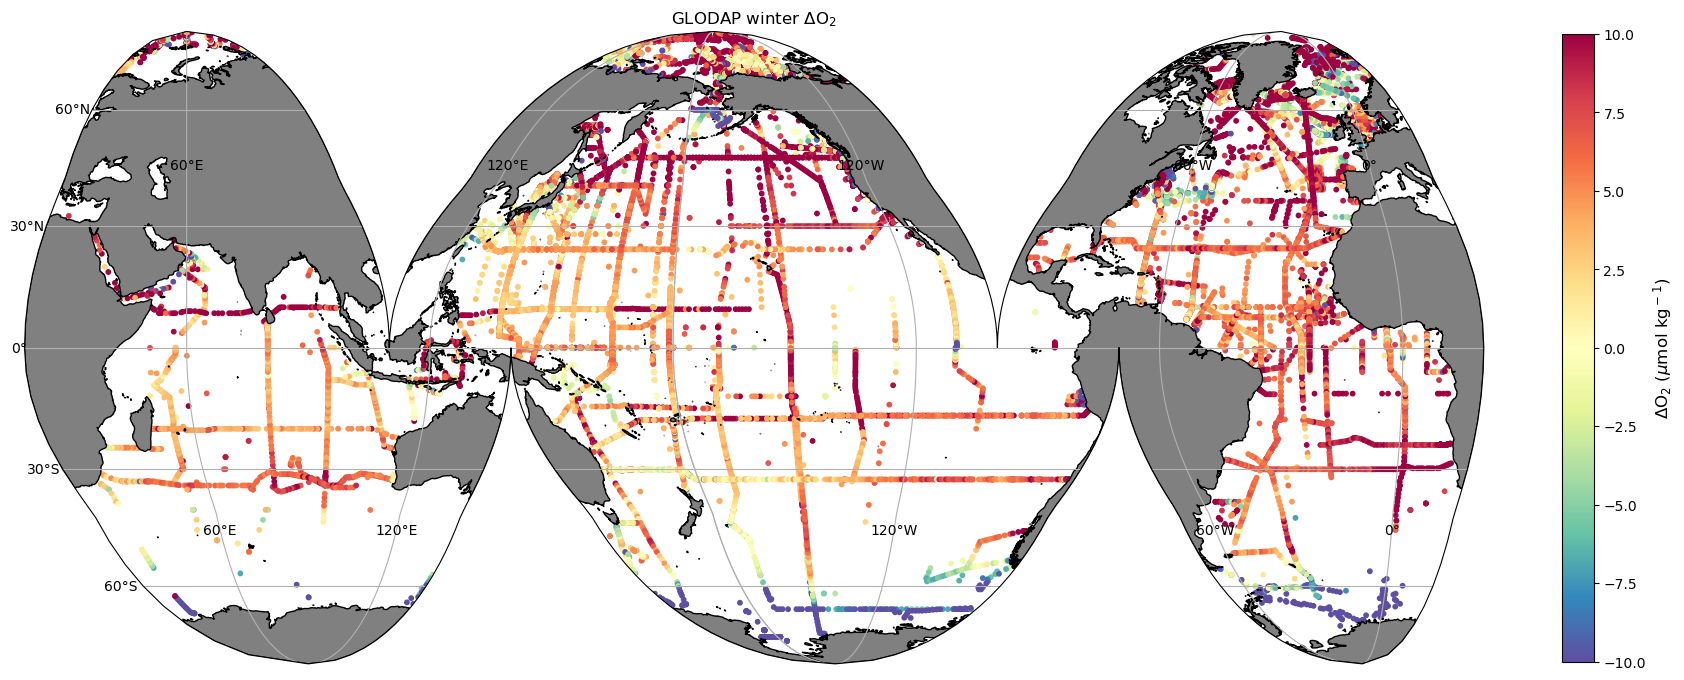

In [120]:
# Plot of winter delta O2 measurements from GLODAP
fig = plt.figure(figsize=(17, 12))
# gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])
# fig, axs = plt.subplot_mosaic([['a.', 'b.'],['c.','d.'],['e.','f.']], layout='constrained', figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = fig.add_subplot(1,1,1, projection=ccrs.InterruptedGoodeHomolosine(central_longitude=-160, globe=None, emphasis='ocean'))
        
# [fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=[.5, .5 ,.5]))

# ax.coastlines()
ax.set_global()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

# # Oxygen offset
sct = ax.scatter(gdap_winter.LONGITUDE, gdap_winter.LATITUDE, 10,gdap_winter.DELTA_O2, vmin=-10, vmax=10, cmap='Spectral_r', transform=ccrs.PlateCarree())

# cbar = plt.colorbar(sct)
cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=.02)#, fraction=0.1, aspect=40, pad=0.08)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$\Delta$O$_2$ ($\mu$mol kg$^-$$^1$)', size=12)


plt.title('GLODAP winter $\Delta$O$_2$')

plt.tight_layout()
plt.savefig(plot_dir + 'GLODAP_Winter_O2_dist.png')

In [122]:
# save out table of cruise expocode, mean dates, lat/lon

#convert datetime to numberic for mean calculation:
gdap_winter['datetime_numeric'] = gdap_winter['datetime'].astype(int)  

gdap_winter_g = gdap_winter.groupby(gdap_winter.G2expocode)


gdap_winter_meta = gdap_winter_g.median()

#convert back to datetime
gdap_winter_meta['datetime_median'] = pd.to_datetime(gdap_winter_mean['datetime_numeric'], unit='ns')

selected_cols = ['G2cruise', 'datetime_median', 'G2year', 'G2month', 'LATITUDE', 'LONGITUDE']
gdap_winter_out = gdap_winter_meta[selected_cols]
print(gdap_winter_out)
gdap_winter_out.to_csv(data_dir + 'GLODAP_WINTER_CRUISE_metadata.csv', index_label='G2expocode')

              G2cruise     datetime_median  G2year  G2month  LATITUDE  \
G2expocode                                                              
06AQ19840719       1.0 1984-08-03 15:22:00  1984.0      8.0   77.6585   
06AQ19860627       2.0 1986-08-04 12:00:00  1986.0      8.0  -65.3515   
06AQ19870704       3.0 1987-08-06 15:27:00  1987.0      8.0   86.1380   
06AQ19890906       4.0 1989-09-21 21:28:00  1989.0      9.0  -64.9500   
06AQ19920521       6.0 1992-06-30 07:57:30  1992.0      6.0  -64.9830   
...                ...                 ...     ...      ...       ...   
90JS20080815     716.0 2008-09-07 00:00:00  2008.0      9.0   73.1920   
CARBOGIB2005     719.0 2006-03-21 00:00:00  2006.0      3.0   35.9110   
IcelandSea       720.0 1997-02-17 19:00:00  1997.0      8.0   68.0000   
IrmingerSea      721.0 1995-10-31 22:00:00  1995.0      8.0   64.3340   
OMEX2            723.0 1999-09-01 00:00:00  1999.0      9.0   42.6165   

              LONGITUDE  
G2expocode              

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/3097102570.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap_winter['datetime_numeric'] = gdap_winter['datetime'].astype(int)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/3097102570.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdap_winter_meta = gdap_winter_g.median()


In [123]:
print(gdap_winter_meta)

              G2cruise  G2station  G2region  G2cast  G2year  G2month  G2day  \
G2expocode                                                                    
06AQ19840719       1.0      376.0       4.0     1.0  1984.0      8.0    3.0   
06AQ19860627       2.0      306.0       1.0     1.0  1986.0      8.0   19.5   
06AQ19870704       3.0      372.0       4.0     1.0  1987.0      8.0    6.0   
06AQ19890906       4.0      159.0       1.0     1.0  1989.0      9.0   12.0   
06AQ19920521       6.0      610.5       1.0     1.0  1992.0      6.0   16.0   
...                ...        ...       ...     ...     ...      ...    ...   
90JS20080815     716.0       59.0       4.0     1.0  2008.0      9.0    9.0   
CARBOGIB2005     719.0       27.0       1.0     1.0  2006.0      3.0   21.0   
IcelandSea       720.0   440080.0       4.0     1.0  1997.0      8.0   17.0   
IrmingerSea      721.0   540980.0       1.0     1.0  1995.0      8.0   10.5   
OMEX2            723.0     1002.5       1.0     1.0 